CARND - Traffic Sign Classification Project
==================================
German traffic sign classification  as a part of the Self-driving Car Nanodegree program at Udacity using LeNet architecture.

-----------
### Step 0: Load the data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import math

from src import loading, utils, lenet, preprocessing, augmentation
from src.lenet import HYPER_PARAMETERS
logger = utils.get_logger('Main Notebook')

In [2]:
training, validation, test = loading.load_all()

-------
### Step 1: Dataset Summary & Exploration

Task: provide a basic summary of the dataset, including an exploratory visualisation of the data set.

In [3]:
summary = utils.get_summary([training, validation, test])
print(summary)

{'TRAINING': {'number-of-examples': 34799, 'image-shape': (32, 32, 3), 'no-of-classes': 43}, 'VALIDATION': {'number-of-examples': 4410, 'image-shape': (32, 32, 3), 'no-of-classes': 43}, 'TEST': {'number-of-examples': 12630, 'image-shape': (32, 32, 3), 'no-of-classes': 43}, 'total-no-of-classes': 43}


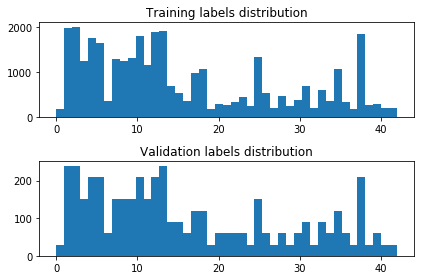

In [4]:
plt.subplot(211)
plt.hist(training.y, bins=summary['total-no-of-classes']);
plt.title('Training labels distribution');

plt.subplot(212)
plt.hist(validation.y, bins=summary['total-no-of-classes']);
plt.title('Validation labels distribution');
plt.tight_layout()
plt.savefig('./docs/images/training-validation-histogram.jpg')

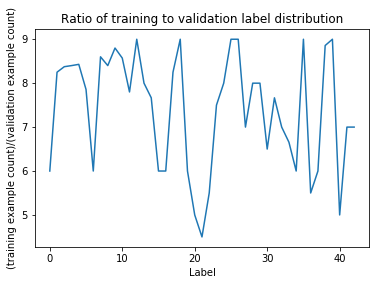

In [5]:
# Show that training/validation is somehow balanced
y_train_counts = utils.group_labels_by_counts(training)
y_validation_counts = utils.group_labels_by_counts(validation)
plt.plot(y_train_counts['counts']/ y_validation_counts['counts']);
plt.title('Ratio of training to validation label distribution');
plt.xlabel('Label');
plt.ylabel('(training example count)/(validation example count)');
plt.savefig('./docs/images/training-validation-sample-size-ratios.jpg')

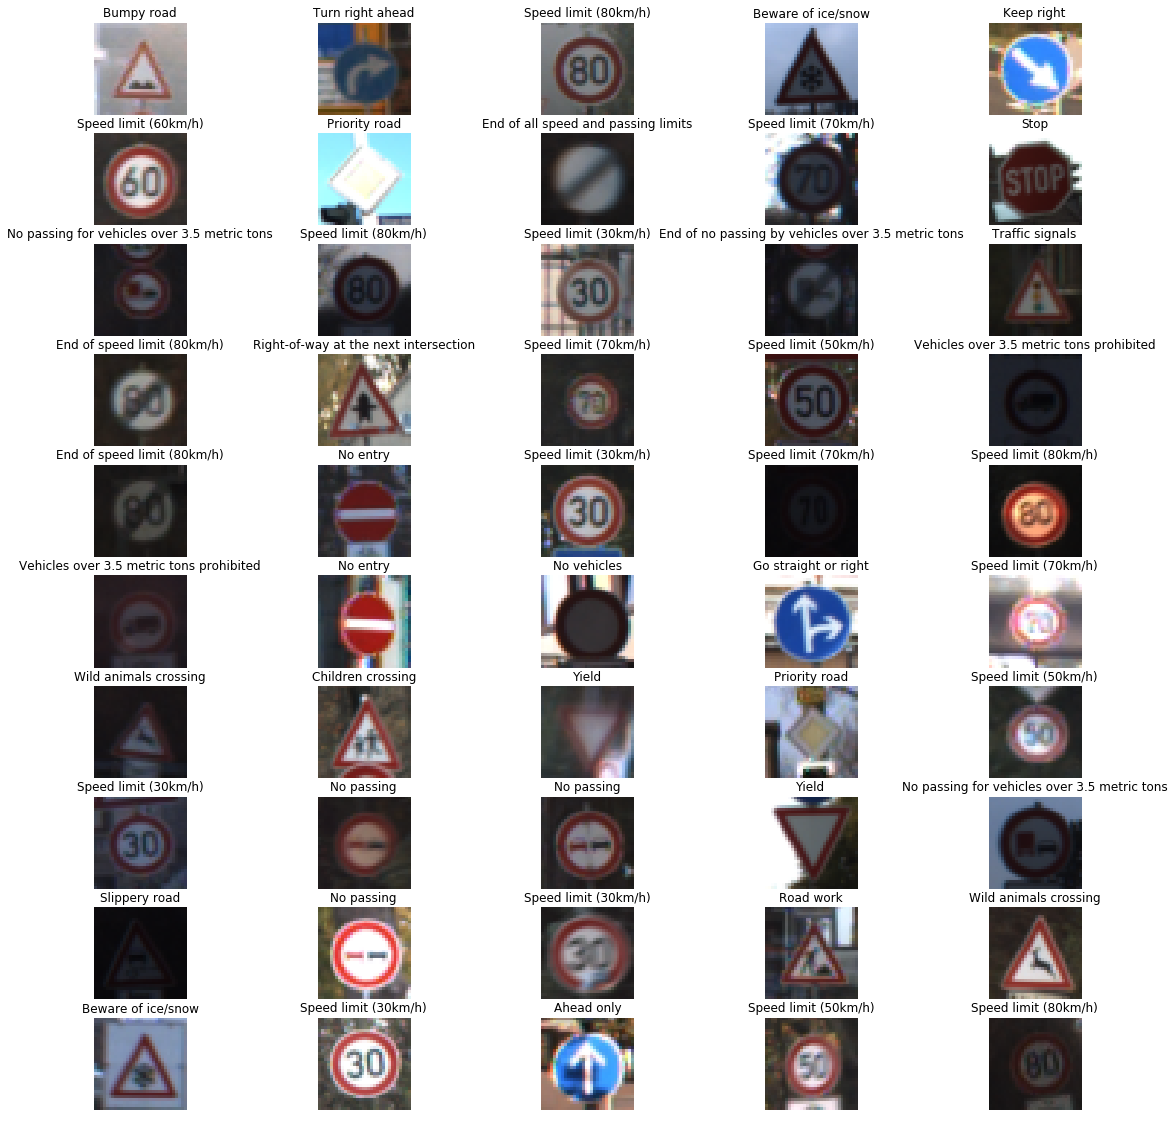

In [6]:
images = []
labels = []
for i in range(50):
    index = random.randint(0, training.count)
    images.append(training.X[index])
    labels.append(utils.to_sign_label(training.y[index]))
utils.plot_and_save(images, labels, './docs/images/25-random-images.jpg', 5)

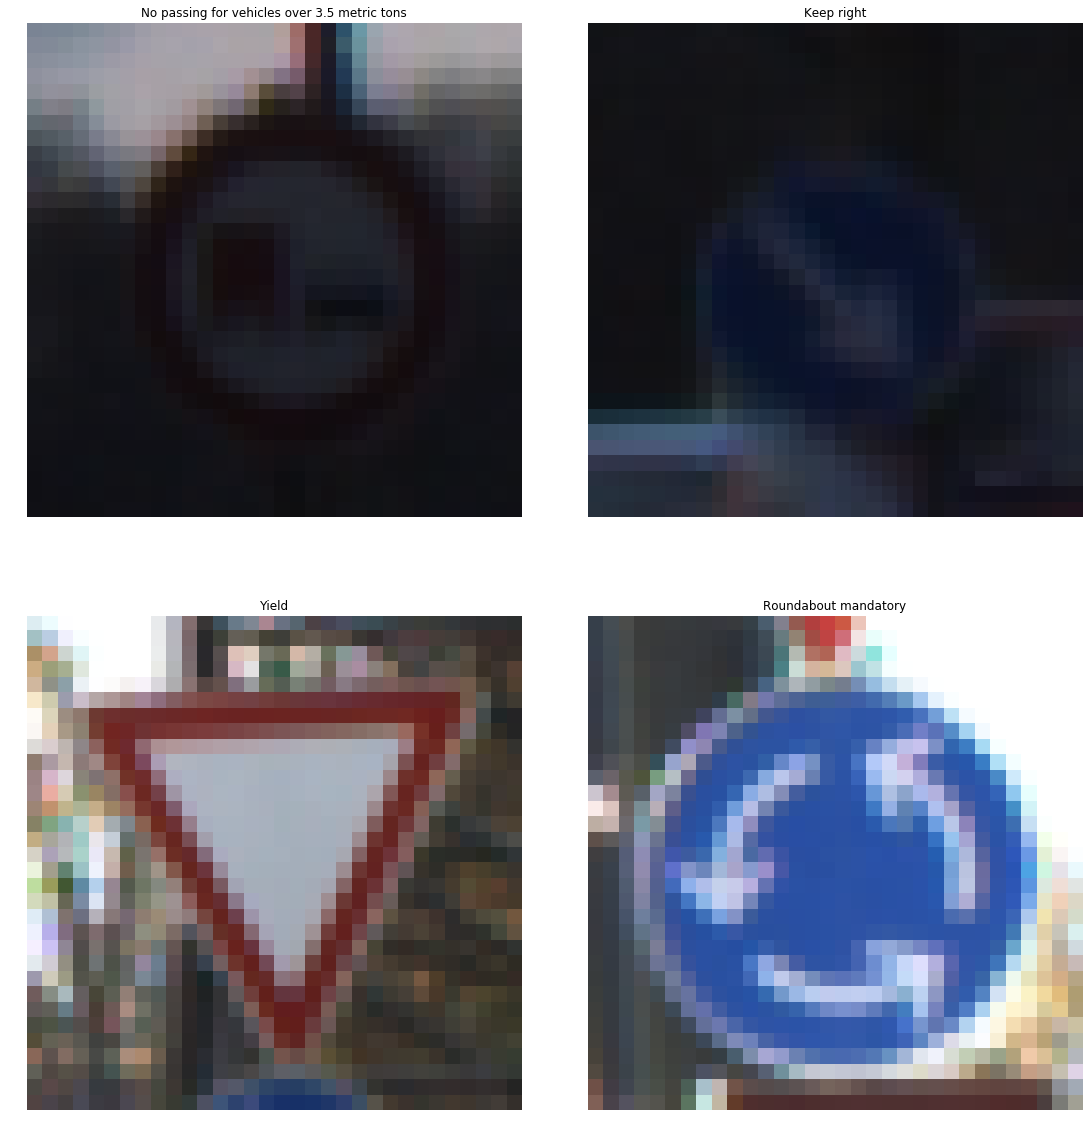

In [7]:
example_images = {
    'with bad lighting': [17894, 14044],
    'good': [22842, 4220]
}
images = []
labels = []
for label, indices in example_images.items():
    for i in indices:
        images.append(training.X[i])
        labels.append(utils.to_sign_label(training.y[i]))

utils.plot_and_save(images, labels, 'docs/images/cherry-pick-good-bad-images.jpg', 2)

----

## Step 2: Design and Test a Model Architecture

#### Pre-process and augment dataset

In [8]:
# List of enabled data augmenters for training data set
TRAINING_DATA_AUGMENTERS = [
    augmentation.GaussianBlurAugmenter(),
    augmentation.AffineTransformAugmenter(),
    augmentation.AffineTransformAugmenter(),
    augmentation.AffineTransformAugmenter(),
    augmentation.AffineTransformAugmenter(),
    augmentation.AffineTransformAugmenter(),
]
d_train = augmentation.Augmenter.apply(training, TRAINING_DATA_AUGMENTERS)

2019-03-17 02:16:37 INFO     Augmenting TRAINING dataset using GAUSSIAN BLUR AUGMENTER...
2019-03-17 02:16:37 INFO     	Parameters: {"ksize": [3, 3]}
2019-03-17 02:16:39 INFO     Augmenting TRAINING dataset using AFFINE_TRANSFORM_AUGMENTER...
2019-03-17 02:16:39 INFO     	Parameters: {"TRANSLATION": [-2, 2], "SCALE": [0.9, 1.1], "ROTATION_IN_DEGREES": [-15, 15]}
2019-03-17 02:16:43 INFO     Augmenting TRAINING dataset using AFFINE_TRANSFORM_AUGMENTER...
2019-03-17 02:16:43 INFO     	Parameters: {"TRANSLATION": [-2, 2], "SCALE": [0.9, 1.1], "ROTATION_IN_DEGREES": [-15, 15]}
2019-03-17 02:16:48 INFO     Augmenting TRAINING dataset using AFFINE_TRANSFORM_AUGMENTER...
2019-03-17 02:16:48 INFO     	Parameters: {"TRANSLATION": [-2, 2], "SCALE": [0.9, 1.1], "ROTATION_IN_DEGREES": [-15, 15]}
2019-03-17 02:16:53 INFO     Augmenting TRAINING dataset using AFFINE_TRANSFORM_AUGMENTER...
2019-03-17 02:16:53 INFO     	Parameters: {"TRANSLATION": [-2, 2], "SCALE": [0.9, 1.1], "ROTATION_IN_DEGREES": [

In [9]:
# List of enabled data pre-processors
PRE_PROCESSORS = [
    preprocessing.GrayScaleConverter(),
    preprocessing.ZNormaliser(),
]

# Perform pre-processing on augmented training and validation data sets
d_train = preprocessing.PreProcessor.apply(d_train, PRE_PROCESSORS)
d_validation = preprocessing.PreProcessor.apply(validation, PRE_PROCESSORS)

2019-03-17 02:17:10 INFO     Running TO_GRAY_SCALE on TRAINING dataset...
2019-03-17 02:17:10 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-17 02:17:20 INFO     Running Z_NORMALISATION on TRAINING dataset...
2019-03-17 02:17:20 INFO     	Parameters: null
2019-03-17 02:17:20 INFO     No means were calculated yet. Calculating score and mean from TRAINING...
2019-03-17 02:17:22 INFO     Normalising TRAINING with mean: 77.34022524973136 and sigma: 65.13104104363924...
2019-03-17 02:17:25 INFO     Running TO_GRAY_SCALE on VALIDATION dataset...
2019-03-17 02:17:25 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-17 02:17:25 INFO     Running Z_NORMALISATION on VALIDATION dataset...
2019-03-17 02:17:25 INFO     	Parameters: null
2019-03-17 02:17:25 INFO     Normalising VALIDATION with mean: 77.34022524973136 and sigma: 65.13104104363924...


2019-03-17 02:17:46 INFO     Running TO_GRAY_SCALE on bad_samples dataset...
2019-03-17 02:17:46 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-17 02:17:46 INFO     Running Z_NORMALISATION on bad_samples dataset...
2019-03-17 02:17:46 INFO     	Parameters: null
2019-03-17 02:17:46 INFO     Normalising bad_samples with mean: 77.34022524973136 and sigma: 65.13104104363924...


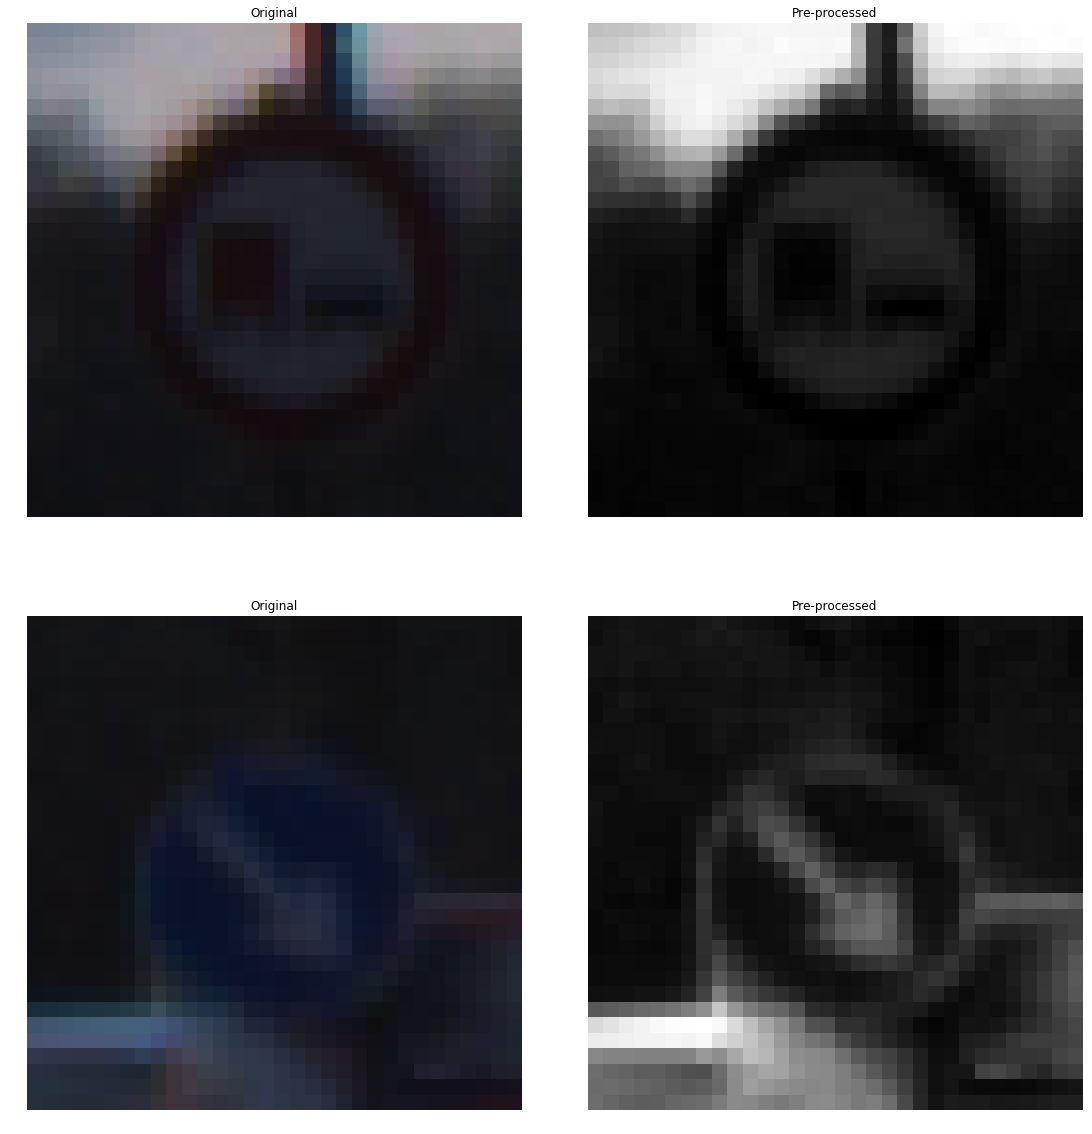

In [10]:
# Apply pre-processing to two of the "bad" images to show the results
BAD_IMAGE_INDEX = [17894, 14044]

bad_x = np.zeros((2, 32, 32, 3))
bad_y = np.zeros(2,)
for i in range(len(BAD_IMAGE_INDEX)):
    bad_x[i,:] = training.X[BAD_IMAGE_INDEX[i]]
    bad_y[i] = training.y[BAD_IMAGE_INDEX[i]]
bad_examples = loading.DataSet('bad_samples', bad_x, bad_y, len(bad_x))

pre_processed = preprocessing.PreProcessor.apply(bad_examples, PRE_PROCESSORS)

images = []
labels = []
for i in range(len(BAD_IMAGE_INDEX)):
    images.append(training.X[BAD_IMAGE_INDEX[i]]);
    labels.append('Original')

    images.append(pre_processed.X[i].squeeze());
    labels.append('Pre-processed')
utils.plot_and_save(images, labels, './docs/images/bad-images-pre-processed.jpg', 2)

#### Start training

In [11]:
# This has been executed in the Udacity Workspace using GPU's to speed up training
logger.info('Hyper-parameters: %s', HYPER_PARAMETERS)

tf.reset_default_graph()
placeholders, operations = lenet.setup_graph()

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    logger.info("Training...")
    for i in range(HYPER_PARAMETERS['EPOCHS']):
        lenet.train_one_epoch(d_train, placeholders, operations)

        training_accuracy = lenet.evaluate(d_train, placeholders, operations)
        validation_accuracy = lenet.evaluate(d_validation, placeholders, operations)

        logger.info("EPOCH {} ...".format(i + 1))
        logger.info("Accuracy on training dataset = {:.3f}".format(training_accuracy))
        logger.info("Validation Accuracy = {:.3f}".format(validation_accuracy))
        logger.info("")

    saver.save(sess, './data/model/lenet')
    logger.info("Model saved")



2019-03-17 02:17:53 INFO     Hyper-parameters: {'LEARNING_RATE': 0.001, 'EPOCHS': 50, 'BATCH_SIZE': 1024, 'KEEP_PROBABILITY_DURING_TRAINING': 0.7, 'mu': 0, 'sigma': 0.1}
2019-03-17 02:17:55 INFO     Training...
2019-03-17 02:18:08 INFO     EPOCH 1 ...
2019-03-17 02:18:08 INFO     Accuracy on training dataset = 0.854
2019-03-17 02:18:08 INFO     Validation Accuracy = 0.816
2019-03-17 02:18:08 INFO     
2019-03-17 02:18:18 INFO     EPOCH 2 ...
2019-03-17 02:18:18 INFO     Accuracy on training dataset = 0.928
2019-03-17 02:18:18 INFO     Validation Accuracy = 0.902
2019-03-17 02:18:18 INFO     
2019-03-17 02:18:29 INFO     EPOCH 3 ...
2019-03-17 02:18:29 INFO     Accuracy on training dataset = 0.958
2019-03-17 02:18:29 INFO     Validation Accuracy = 0.922
2019-03-17 02:18:29 INFO     
2019-03-17 02:18:39 INFO     EPOCH 4 ...
2019-03-17 02:18:39 INFO     Accuracy on training dataset = 0.970
2019-03-17 02:18:39 INFO     Validation Accuracy = 0.932
2019-03-17 02:18:39 INFO     
2019-03-17 02

2019-03-17 02:25:22 INFO     EPOCH 42 ...
2019-03-17 02:25:22 INFO     Accuracy on training dataset = 0.998
2019-03-17 02:25:22 INFO     Validation Accuracy = 0.972
2019-03-17 02:25:22 INFO     
2019-03-17 02:25:32 INFO     EPOCH 43 ...
2019-03-17 02:25:32 INFO     Accuracy on training dataset = 0.998
2019-03-17 02:25:32 INFO     Validation Accuracy = 0.970
2019-03-17 02:25:32 INFO     
2019-03-17 02:25:43 INFO     EPOCH 44 ...
2019-03-17 02:25:43 INFO     Accuracy on training dataset = 0.999
2019-03-17 02:25:43 INFO     Validation Accuracy = 0.973
2019-03-17 02:25:43 INFO     
2019-03-17 02:25:54 INFO     EPOCH 45 ...
2019-03-17 02:25:54 INFO     Accuracy on training dataset = 0.998
2019-03-17 02:25:54 INFO     Validation Accuracy = 0.967
2019-03-17 02:25:54 INFO     
2019-03-17 02:26:04 INFO     EPOCH 46 ...
2019-03-17 02:26:04 INFO     Accuracy on training dataset = 0.998
2019-03-17 02:26:04 INFO     Validation Accuracy = 0.963
2019-03-17 02:26:04 INFO     
2019-03-17 02:26:15 INFO 

---
## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load the Images Downloaded from the Internet

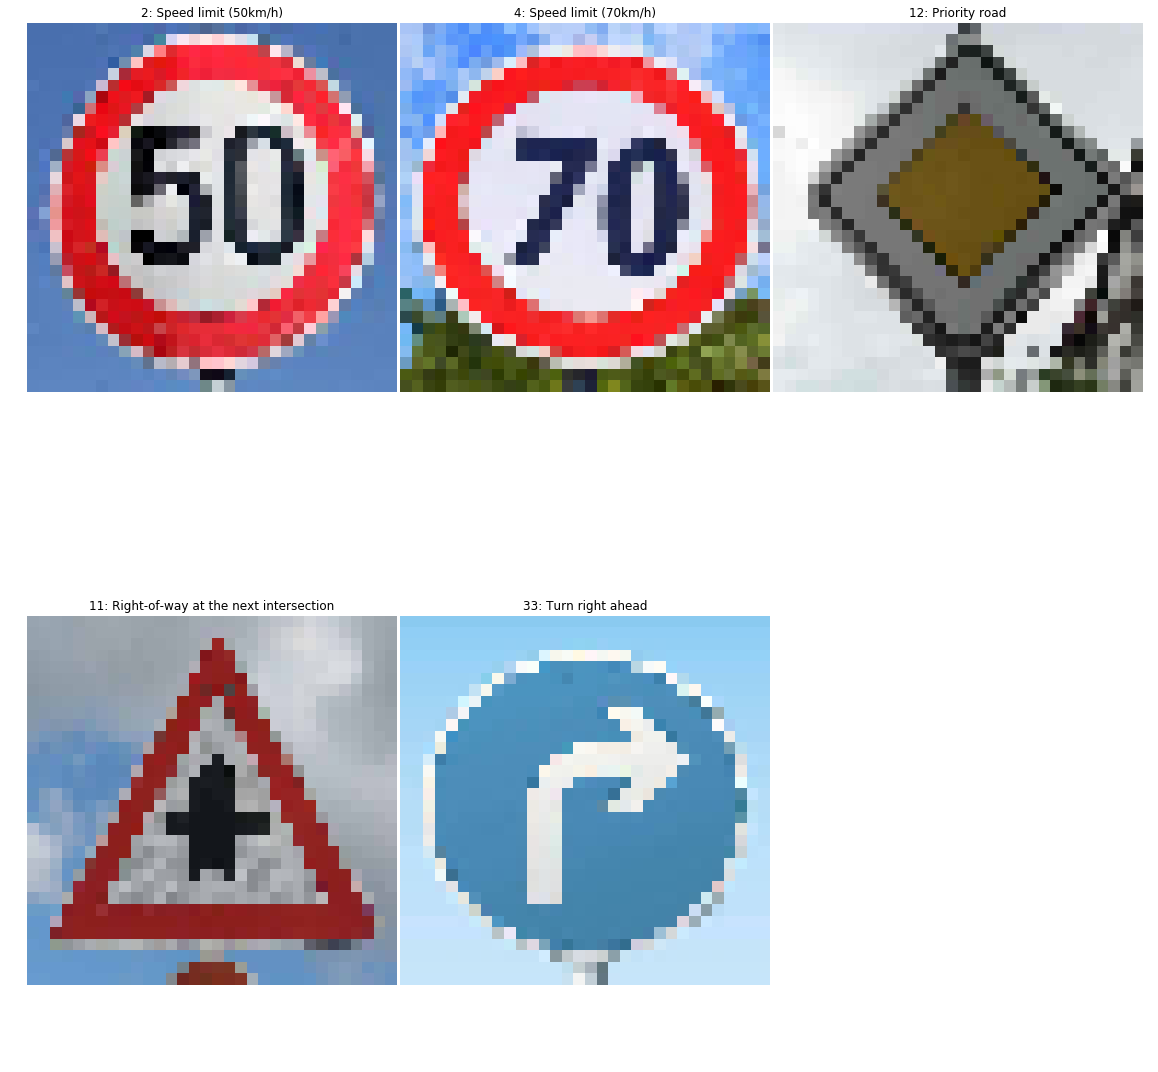

In [12]:
FROM_INTERNET_IMAGE_PATHS = [
    "max-50.jpeg",
    "max-70.jpeg",
    "priority-road.jpg",
    "right-of-way-at-next-intersection.jpg",
    "turn-right-ahead.jpg"
]
FROM_INTERNET_LABELS = [2, 4, 12, 11, 33]
from_internet_images = [utils.read_image_for_lenet('./data/traffic-signs-from-internet/' + p) for p in FROM_INTERNET_IMAGE_PATHS]

plt_labels = ['{}: {}'.format(l, utils.to_sign_label(l)) for l in FROM_INTERNET_LABELS]
utils.plot_and_save(from_internet_images, plt_labels, './docs/images/images-from-internet-resized.jpg', 3)

In [13]:
# Prepare dataset
d_x = np.stack(from_internet_images)
d_y = np.array(FROM_INTERNET_LABELS)

from_internet_dataset = loading.DataSet('From Internet', d_x, d_y, len(d_x))
logger.info(utils.get_summary([from_internet_dataset]))
from_internet_dataset = preprocessing.PreProcessor.apply(from_internet_dataset, PRE_PROCESSORS)

2019-03-17 02:26:58 INFO     {'From Internet': {'number-of-examples': 5, 'image-shape': (32, 32, 3), 'no-of-classes': 5}, 'total-no-of-classes': 5}
2019-03-17 02:26:58 INFO     Running TO_GRAY_SCALE on From Internet dataset...
2019-03-17 02:26:58 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-17 02:26:58 INFO     Running Z_NORMALISATION on From Internet dataset...
2019-03-17 02:26:58 INFO     	Parameters: null
2019-03-17 02:26:58 INFO     Normalising From Internet with mean: 77.34022524973136 and sigma: 65.13104104363924...


### Predict the Sign Type for Each Image

In [14]:
logger.info('Hyper-parameters: %s', HYPER_PARAMETERS)

tf.reset_default_graph()
placeholders, operations = lenet.setup_graph()

softmax_logits = tf.nn.softmax(operations.logits)
all_labels = tf.nn.top_k(softmax_logits, k=43)
top_5_labels = tf.nn.top_k(softmax_logits, k=5)

saver2 = tf.train.Saver()
with tf.Session() as sess:
    saver2.restore(sess, "./data/model/lenet")

    accuracy = lenet.evaluate(from_internet_dataset, placeholders, operations)
    logger.info("Accuracy = {:.3f}".format(accuracy))
    
    top_5_results = sess.run(top_5_labels, feed_dict={
        placeholders.x: from_internet_dataset.X,
        placeholders.keep_probability: 1
    })
    all_labels_results = sess.run(all_labels, feed_dict={
        placeholders.x: from_internet_dataset.X,
        placeholders.keep_probability: 1
    })



2019-03-17 02:27:10 INFO     Hyper-parameters: {'LEARNING_RATE': 0.001, 'EPOCHS': 50, 'BATCH_SIZE': 1024, 'KEEP_PROBABILITY_DURING_TRAINING': 0.7, 'mu': 0, 'sigma': 0.1}
INFO:tensorflow:Restoring parameters from ./data/model/lenet
2019-03-17 02:27:11 INFO     Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [16]:
for i in range(from_internet_dataset.count):
    print('Actual: {}, {}'.format(FROM_INTERNET_LABELS[i], utils.to_sign_label(FROM_INTERNET_LABELS[i])))
    for j in range(top_5_results.indices.shape[1]):
        predicted_label = top_5_results.indices[i, j]
        print("\t[{}] {}: {}".format(predicted_label, utils.to_sign_label(predicted_label), top_5_results.values[i, j]))

Actual: 2, Speed limit (50km/h)
	[1] Speed limit (30km/h): 0.5004217624664307
	[2] Speed limit (50km/h): 0.4990701675415039
	[38] Keep right: 0.0005065919831395149
	[40] Roundabout mandatory: 1.4380449329109979e-06
	[0] Speed limit (20km/h): 3.937442727419693e-08
Actual: 4, Speed limit (70km/h)
	[4] Speed limit (70km/h): 1.0
	[1] Speed limit (30km/h): 1.668648685893004e-08
	[14] Stop: 4.900359007464772e-10
	[0] Speed limit (20km/h): 2.9491553643623547e-10
	[39] Keep left: 2.1173446329569856e-10
Actual: 12, Priority road
	[12] Priority road: 1.0
	[2] Speed limit (50km/h): 7.180488981184396e-10
	[13] Yield: 3.4771552304135867e-10
	[1] Speed limit (30km/h): 2.2085834550100714e-10
	[15] No vehicles: 1.3284411765068782e-11
Actual: 11, Right-of-way at the next intersection
	[11] Right-of-way at the next intersection: 0.9999597072601318
	[21] Double curve: 3.944876152672805e-05
	[12] Priority road: 5.299477265907626e-07
	[23] Slippery road: 1.7361352888656256e-07
	[30] Beware of ice/snow: 1.3

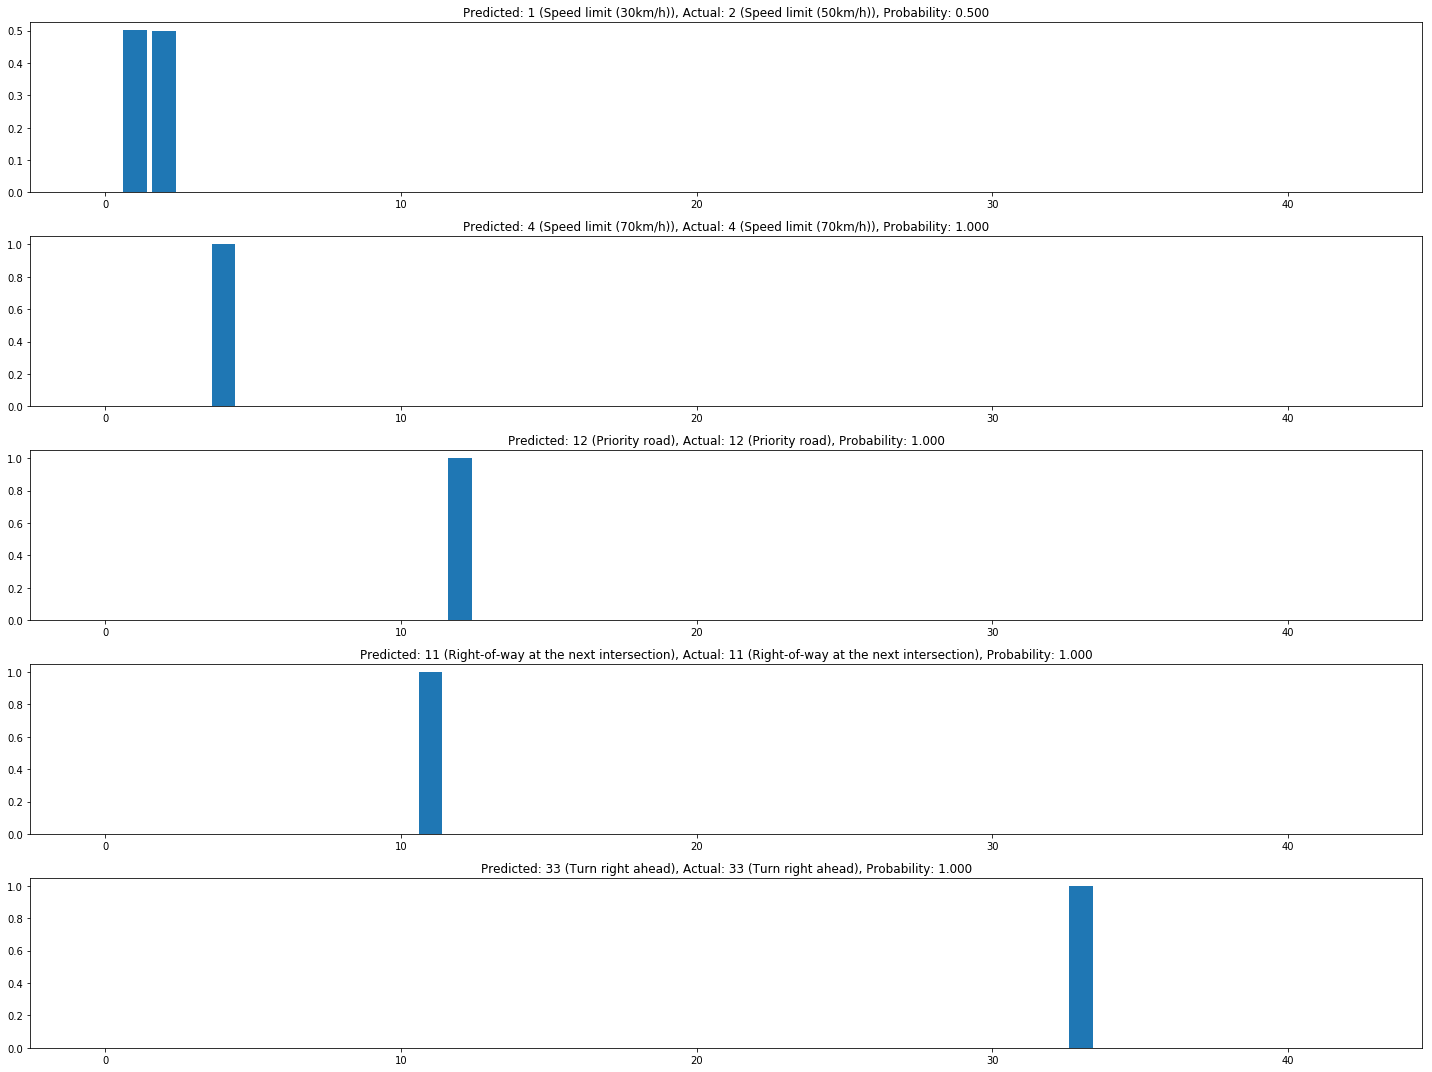

In [17]:
plt.subplots(figsize=(20, 15))
for i in range(from_internet_dataset.count):
    plt.subplot(from_internet_dataset.count, 1,i+1)
    plt.bar(x=all_labels_results.indices[i], height=all_labels_results.values[i])
    predicted_label = all_labels_results.indices[i][0]
    actual_label = FROM_INTERNET_LABELS[i]
    probability = all_labels_results.values[i][0]
    plt.title("Predicted: {} ({}), Actual: {} ({}), Probability: {:.3f}".format(predicted_label, 
                                                                               utils.to_sign_label(predicted_label),
                                                                               actual_label, 
                                                                               utils.to_sign_label(actual_label),
                                                                               probability))

plt.tight_layout()
plt.savefig("docs/images/softmax-probabilities-on-images-from-internet.jpg")


2019-03-17 02:28:17 INFO     Running TO_GRAY_SCALE on Max 80 dataset...
2019-03-17 02:28:17 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-17 02:28:17 INFO     Running Z_NORMALISATION on Max 80 dataset...
2019-03-17 02:28:17 INFO     	Parameters: null
2019-03-17 02:28:17 INFO     Normalising Max 80 with mean: 77.34022524973136 and sigma: 65.13104104363924...
INFO:tensorflow:Restoring parameters from ./data/model/lenet


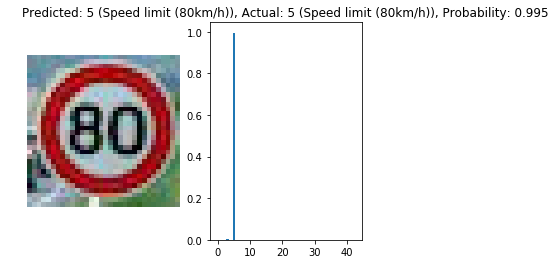

In [19]:
MAX_80_LABEL = 5
MAX_80_IMG_PATH = './data/traffic-signs-from-internet/max-80.jpg'
max_80_img = utils.read_image_for_lenet(MAX_80_IMG_PATH)
max_80_dataset = loading.DataSet('Max 80', max_80_img.reshape(1, 32, 32, 3), [MAX_80_LABEL], 1)
d_max_80 = preprocessing.PreProcessor.apply(max_80_dataset, PRE_PROCESSORS)

tf.reset_default_graph()
placeholders, operations = lenet.setup_graph()

softmax_logits = tf.nn.softmax(operations.logits)
all_labels = tf.nn.top_k(softmax_logits, k=43)

saver3 = tf.train.Saver()
with tf.Session() as sess:
    saver3.restore(sess, "./data/model/lenet")
    all_labels_results = sess.run(all_labels, feed_dict={
        placeholders.x: d_max_80.X,
        placeholders.keep_probability: 1
    })

plt.subplot(121)
plt.imshow(max_80_img)
plt.axis('off')
a = plt.subplot(122)
plt.bar(x=all_labels_results.indices[0], height=all_labels_results.values[0])
predicted_label = all_labels_results.indices[0][0]
probability = all_labels_results.values[0][0]
plt.title("Predicted: {} ({}), Actual: {} ({}), Probability: {:.3f}".format(predicted_label, 
                                                                           utils.to_sign_label(predicted_label),
                                                                           MAX_80_LABEL, 
                                                                           utils.to_sign_label(MAX_80_LABEL),
                                                                           probability));
plt.savefig("docs/images/softmax-probabilities-on-max-80-sign.jpg")

### Visualize network

This Section is not required to complete but acts as an additional excersise for understanding the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.
Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the LeNet lab's feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper End-to-End Deep Learning for Self-Driving Cars in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

In [20]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

---------------
## Test Dataset

In [21]:
tf.reset_default_graph()
placeholders, operations = lenet.setup_graph()

d_test = preprocessing.PreProcessor.apply(test, PRE_PROCESSORS)

saver3 = tf.train.Saver()
with tf.Session() as sess:
    saver3.restore(sess, "./data/model/lenet")
    accuracy = lenet.evaluate(d_test, placeholders, operations)
    logger.info("Accuracy = {:.3f}".format(accuracy))

2019-03-17 02:28:51 INFO     Running TO_GRAY_SCALE on TEST dataset...
2019-03-17 02:28:51 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
2019-03-17 02:28:51 INFO     Running Z_NORMALISATION on TEST dataset...
2019-03-17 02:28:51 INFO     	Parameters: null
2019-03-17 02:28:51 INFO     Normalising TEST with mean: 77.34022524973136 and sigma: 65.13104104363924...
INFO:tensorflow:Restoring parameters from ./data/model/lenet
2019-03-17 02:28:52 INFO     Accuracy = 0.953
